In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from transformers import BitsAndBytesConfig
import gc
import torch

def z_fication(tmp_text):
    tt = tmp_text.copy()
    for i in range(len(tt)):  # Перебираем элементы по индексу
        tt[i] = tt[i].replace('3', 'Z')
        tt[i] = tt[i].replace('З', 'Z')
        tt[i] = tt[i].replace('з', 'Z')
        tt[i] = tt[i].replace('в', 'V')
        tt[i] = tt[i].replace('В', 'V')
        tt[i] = tt[i].replace('8', 'В')
         
    result = ' '.join(tt)
    return result

def img_plot(img):
    plt.imshow(img)
    plt.axis('off')  # Скрыть оси
    plt.show()

def clear_memory():
    # global model, tokenizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    # model = None
    # tokenizer = None
    gc.collect()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16
)

model = None
tokenizer = None


model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    quantization_config=bnb_config,
    device_map="auto"
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
def text_extraction_z(thresh_pil, preview = False):
    clear_memory()  # Освобождаем GPU
    
    # thresh_pil = Image.fromarray(img_path)
    # thresh_pil = Image.open(img_path)


    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": thresh_pil,
                },
                {"type": "text", "text": "Выведи только текст который есть на изображении, построчно, выведи весь текст и не пиши ничего лишнего, текст может быть на английском и русском."},
            ],
        }
    ]

    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")


    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=512)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] 
        for in_ids, out_ids in zip(inputs['input_ids'], generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    tmp_text = output_text[0].split('\n')
    if preview:
        img_plot(thresh_pil)
        print(output_text)
        print(tmp_text)
        print(z_fication(tmp_text))
    clear_memory()  # Освобождаем GPU
    return z_fication(tmp_text)

In [12]:
import cv2
from paddleocr import PaddleOCR
import numpy as np
import matplotlib.pyplot as plt


def img_plot(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Инициализация (используем только детектор DBnet)
ocr = PaddleOCR(
    det_model_dir='en+rus_PP-OCRv4_det',  # Версия с DBnet
    rec_model_dir='en+rus_PP-OCRv4_rec', 
    use_gpu=True,
    rec=False
)

def super_resolution(image, scale=4):
        height, width = image.shape[:2]
        return cv2.resize(image, (width*scale, height*scale), 
                        interpolation=cv2.INTER_CUBIC)

def remove_background(region):
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def text_detection(img_path):
    result = ocr.ocr(img_path, cls=False)
    img_rect = cv2.imread(img_path)

    cropped_regions = []
    delta = 5 
    
    for i, det in enumerate(result[0]):
        points = np.array(det[0], dtype=np.int32)
        x, y, w, h = cv2.boundingRect(points)

        x1 = max(0, x - delta)
        y1 = max(0, y - delta)
        x2 = min(img_rect.shape[1], x + w + delta)
        y2 = min(img_rect.shape[0], y + h + delta)

        region = img_rect[y1:y2, x1:x2].copy()
        region_rgb = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)
        cropped_regions.append(region_rgb)

        cv2.polylines(img_rect, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        
    img_rgb = cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB)  
    img_plot(img_rgb)
    return cropped_regions

def z_ocr(path, preview = False, crop_region = True):
    img_plot(Image.open(path))
    if crop_region:
        regions = text_detection(path)
        result = []
        for temp in regions:
            pil_temp = Image.fromarray(temp)
            result.append(text_extraction_z(pil_temp, preview))
        return " ".join(result)
    else:
         pil_temp = Image.open(path)
         result = text_extraction_z(pil_temp, preview)
         return result

[2025/05/03 13:17:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='en+rus_PP-OCRv4_det', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='en+rus_PP-OCRv4_rec', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='C:\\Users\\vadim\\AppData\\Roa

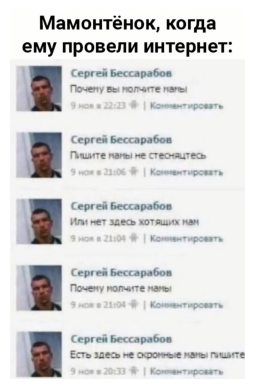

Мамонтёнок, когда ему проVели интернет:  Сергей БессарабоV Почему Vы молчите мамы  9 ноя V 22:2Z | КомментироVать  Сергей БессарабоV Пишите мамы не стесняйтесь  9 ноя V 21:06 | КомментироVать  Сергей БессарабоV Или нет Zдесь хотящих мам  9 ноя V 21:04 | КомментироVать  Сергей БессарабоV Почему молчите мамы  9 ноя V 21:04 | КомментироVать  Сергей БессарабоV Есть Zдесь не скромные мамы пишите


In [ ]:

# text_extraction_z('tst/88.jpg')
# import time
# elpsd_times = []
# for i in range(92):
#     start_time = time.perf_counter()

#     path = 'tst/' + str(i+1) + '.jpg'
#     txt = z_ocr(path)
#     print(txt)
#     elapsed_time = time.perf_counter() - start_time
#     elpsd_times.append(elapsed_time)
#     print('Time spent', elapsed_time)
print(z_ocr('tst/8.jpg', crop_region = False))

In [ ]:

# default: Load the model on the available device(s)
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto"
#     , device_map="auto"
# )

# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct",
#     load_in_8bit=True
#     # , device_map="auto"
# ).to('cuda')

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.


# EASYOCR_1

# import easyocr

# reader = easyocr.Reader(
#     lang_list=['ru', 'en'],
#     gpu=True,          # Важно!
#     model_storage_directory='model_folder',
#     download_enabled=True
# )


# img_path = "tst/kynilover.png"

# img = cv2.imread(img_path)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)[1]  # Инвертирование для белого текста

# result = reader.readtext(thresh, detail=0)

# img_plot(thresh)
# print("Распознанный текст:", result)

# EASYOCR_2

# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# import easyocr

# def auto_detect_params(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    
#     peaks = np.where(hist > hist.mean() * 3)[0]
#     text_peak = peaks[peaks > 200]  # Пики в светлой области
    
#     return {
#         'threshold': int(np.mean(text_peak)) if len(text_peak) > 0 else 220,
#         'clip_limit': max(1.0, 3.0 - (gray.std() / 50)),
#         'morph_size': max(1, int(gray.shape[0] / 300))
#     }

# def adaptive_text_extraction(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     params = auto_detect_params(img)
    
#     clahe = cv2.createCLAHE(
#         clipLimit=params['clip_limit'],
#         tileGridSize=(8, 8)
#     )
#     equalized = clahe.apply(gray)
    
#     _, threshold = cv2.threshold(
#         equalized,
#         params['threshold'],
#         255,
#         cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
#     )
    
#     kernel = np.ones((params['morph_size'], params['morph_size']), np.uint8)
#     cleaned = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    
#     return cleaned

# def detect_background_type(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    
#     # Классификация фона
#     if np.argmax(hist) > 200:
#         return "light_background"
#     elif np.argmax(hist) < 50:
#         return "dark_background"
#     else:
#         return "complex_background"
    
# def smart_text_extraction(img):
#     bg_type = detect_background_type(img)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
#     if bg_type == "light_background":
#         # Для светлого фона
#         inverted = cv2.bitwise_not(gray)
#         return cv2.threshold(inverted, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
#     elif bg_type == "dark_background":
#         # Для темного фона
#         return cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]
    
#     else:
#         # Для сложного фона
#         return adaptive_text_extraction(img)

# def preprocess_for_ocr(img_path):
#     img = cv2.imread(img_path)
#     processed = smart_text_extraction(img)
    
#     # Сохраняем временный файл
#     temp_path = "tst/temp_processed.jpg"
#     cv2.imwrite(temp_path, processed)
    
#     return temp_path

# # Использование
# reader = easyocr.Reader(
#     lang_list=['ru', 'en'],
#     gpu=True,          # Важно!
#     model_storage_directory='model_folder',
#     download_enabled=True
# )


# img_path = "tst/photo_2025-04-28_21-40-21.jpg"

# processed_img = preprocess_for_ocr(img_path)
# raw_result = reader.readtext(processed_img, detail=0)
# combined_text = " ".join(raw_result)
# result = combined_text

# plot = Image.open(processed_img)

# img_plot(plot)
# print("Распознанный текст:", result)